 ### <ins> Background
  Mostly CTCF and Cohesin drive the insulation of genomic regions that form domains with high intra-domain interaction frequency. These domains are reffered as Topologically Associated Domains and can be further organised to higher order genomic domains. A single domain can also contain several subTADs as well. Chromatin conformation experiments paired with deep sequencing can capture these interactions by measuring the reads(per bin) from chimeric fragments that map to distal regions on the genome. As a a result a symmetrical matrix is produced where each entry corresponds to the interaction frequency of the bin at position i and position j.


### <ins> Steps
- Compute insulation scores(discrete set of numbers)

- Smoothen the data to reduce background noise

- Compute the regions where valleys and peaks exist 

- Compute the significance of each valley

- Set a threshold and filter vallays

- Plot the results

### <ins> A function that computes insulation scores

In [1]:
#Iterate through all bins and and compute it's insulation score.
#Normalize insulations scores by dividing the score of ech bin 
# with the mean isulation score of the cromosome and finally log2 
# transforming the score

def get_insulation_scores(matrix, filter_size):

    insulation_scores = []
    #get the length of the diagonal
    import math
    len_diag = len(np.diagonal(matrix))
    for i in range(int(filter_size/2), len_diag - int(filter_size/2)):
        filter = matrix[i:i +filter_size,i:i+ filter_size]
    
        insulation_scores.append(np.sum(filter))
    
    insulation_scores = np.array([insulation_scores])
    avg_insulation_score = np.mean(insulation_scores)

    def log2_ratio(a, b):
        if a / b == 0:
            return(-1)
        elif a /b > 2:
            return(1)
        elif a/b < 0.5:
            return(-1)
        else:
            return(np.log2(a / b))

    norm_insulation_scores = np.apply_along_axis(func1d= log2_ratio, arr = insulation_scores, b = avg_insulation_score, axis = 0)
    
    
    return(norm_insulation_scores)

### <ins> A function that computes delta scores

In [2]:
# #Compute the delta score used in the Crane et al paper
# def get_delta_scores(normalized_insulation_scores, delta_window):
#     normalized_insulation_scores = normalized_insulation_scores.flat
#     delta_vector = []
#     start = delta_window
#     end = len(normalized_insulation_scores) - delta_window
#     for i in range(start, end):
        
#         upper_pos = normalized_insulation_scores[i]
#         lower_pos = normalized_insulation_scores[i+delta_window]
#         upper_mean = np.mean(upper_pos)
#         lower_mean = np.mean(lower_pos)

#         delta_vector.append(upper_mean - lower_mean)

#     return(np.array(delta_vector))



    

### <ins> A function for data smoothing

In [3]:
# Function to perform sliding window mean
#each bin is transformed to the mean score of its surrounding bins
def sliding_window_mean(data, window_size):
    # Create an empty array for the smoothed data
    smoothed_data = np.zeros_like(data)
    # Perform sliding window mean
    for i in range(len(data)):
        window_start = max(0, i - window_size // 2)
        window_end = min(len(data), i + window_size // 2 + 1)
        smoothed_data[i] = np.mean(data[window_start:window_end])
    return smoothed_data


### <ins> A function to compute valleys

In [ ]:
# #A function to compute valleys based on the insulation scores of the bins
# def find_valleys(x_data, y_data):
#     valleys = []
#     n = len(y_data)
    
#     for i in range(1, n - 1):
#         if y_data[i] < y_data[i-1] and y_data[i] < y_data[i+1]:
#             valleys.append((x_data[i], y_data[i]))
    
#     return valleys


# #valleys = find_valleys(bin_positions, insulation_scores_1.flat)


### <ins> A function to compute prominence

In [ ]:
#Prominence is a metric used to identify how significant a peak is 
# compared to each surrounding peaks. It is a metric used to extract actual peaks from noise
# This function does the exact same thing but instead of looking for peaks looks for
# significant valleys

#Note that because the function is not a set of discrete values a set of 1000 ordered numbers 
# are used to find the maximum of the interval in order to compute the left and the right base of the valley#
def compute_prominence(spline, valley_positions):
   valley_prominences = []
   for valley_i in range(1,len(valley_positions) -1):
      print('{:.2f}'.format(valley_i/len(valley_positions)))
      
      valley_position = valley_positions[valley_i]
      valley_score = spline(valley_position)


      j = 1
      k = 1 

      left_valley_position = valley_positions[valley_i - j]
      left_valley_score = spline(left_valley_position)

      right_valley_position = valley_positions[valley_i + k]
      right_valley_score = spline(right_valley_position)

      while valley_score < left_valley_score and j != valley_i:
         j+=1
         left_valley_position = valley_positions[valley_i - j]
         left_valley_score = spline(left_valley_position)
      left_base = max([spline(x) for x in np.linspace(left_valley_position, valley_position, 1000)])

      
      while valley_score < right_valley_score and (k  + valley_i) < (len(valley_positions) -1 ) :
         
         k+=1
         
         if (k  + valley_i) >= (len(valley_positions)) :
            #print('---', peak_i + k)
            break
         else:
            #print('-------', peak_i + k)
            #print('k = ', k, 'peak i = ', peak_i)
            #print(len(peak_positions))
            right_valley_position = valley_positions[valley_i + k]
            right_valley_score = spline(right_valley_position)
         
      right_base = max([spline(x) for x in np.linspace(right_valley_position, valley_position, 1000)])
      valley_prominence = abs(valley_score - min(left_base,right_base))
      valley_prominences.append((valley_position,valley_prominence))
   return(valley_prominences) 
        

### <ins> A function to compute peaks and valleys using the derivative of the graph

In [6]:
#This is a function used to compute the regions where local maxima and minima exist
#Insulation scores represent a discrete set of values. These scores are converted to 
# a continuous set of values by fitting an spline that gets through the data. Spline 
# is essentially a function that perfectly fits the insulations scores. The regios where
#  the derivative of the function equals to 0 are computed to get regions where minima or maxima exist


def get_peaks_and_valleys(x,y):
    
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import UnivariateSpline
    from scipy.optimize import root_scalar

    zeros = []
    gradient = []
    zero_idx = []

    spline = UnivariateSpline(x, y, s=0)
    spline_derivative = spline.derivative()

    for i in range(len(x) - 1):
        if np.sign(spline_derivative(x[i])) != np.sign(spline_derivative(x[i + 1])):
            #print(np.sign(spline_derivative(x[i])))
            #print(np.sign(spline_derivative(x[i+1])))
            root_result = root_scalar(spline_derivative, bracket=[x[i], x[i + 1]])
            if root_result.converged:
                zeros.append(root_result.root)
                zero_idx.append(x[i])
                gradient.append(int(np.sign(spline_derivative(x[i]))))
    #return(1,2,3)
    return(np.array(zeros), np.array(zero_idx), np.array(gradient), spline)

### <ins> A function to plot the heatmap and the positions of the valleys


In [7]:
def heatmap_with_boundaries(matrix,valley_list, n_bin):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    import math

    val = [i for i in valley_list if i <= n_bin]
    # Define your custom colormap
    colors = ['white', 'black']  # Adjust colors as needed
    cmap_name = 'white_to_red'
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(7, 7))  # Adjust figsize as needed

    # Display the image using imshow with your custom colormap
    im = ax.imshow((stand_data[0:n_bin,0:n_bin]), cmap=custom_cmap, interpolation='nearest')
    plt.scatter(val,val, s = 24)
    
    #plt.xlim((stop_bin,start_bin))
    #plt.ylim((start_bin,stop_bin))
    #plt.scatter(significant[:5],significant[:5], c = 'black', s = 2)
    # Add colorbar for reference
    fig.colorbar(im, ax=ax, orientation='vertical')

    plt.show()


### Load the data

In [8]:
import numpy as np
import os
working_directory = os.getcwd()
contact_file = f'{working_directory}/data_for_assignments/chr11_contact_matrix.tsv'

data = np.loadtxt(contact_file, delimiter = '\t')


### <ins> Combine the functions to a single one

In [9]:
filter_size_1 = 5
delta_window_1 = 10
smoothing_window = 10
prominence_threshold = 0.05
n = 29


def compute_TADs(data, filter_size = 5, smoothing_window = 5,prominence_threshold =0.05 , n = 29):
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib import pyplot as plt
    import pandas as pd
    insulation_scores_1 = get_insulation_scores(data, filter_size = filter_size)
    # delta_scores = get_delta_scores(insulation_scores_1, delta_window=delta_window_1)

    bin_positions = list(range(int(filter_size/2), len(np.diagonal(data)) - int(filter_size/2)))
    delta_bin_positions = list(range(int(filter_size/2) + delta_window_1 , len(np.diagonal(data)) - int(filter_size_1/2) - delta_window_1 ))

    # Compute sliding window mean for y data

    smooth_insulation_scores = sliding_window_mean(insulation_scores_1.flat, smoothing_window)
    #smooth_insulation_scores = insulation_scores_1
    #Compute the number of peaks and valleys before smoothening
    zeros, zero_idx, gradient, spline  = get_peaks_and_valleys(bin_positions, insulation_scores_1.flatten())
    peaks = gradient == 1
    valleys = gradient == -1
    print('{} peaks and {} valleys found before smoothing.'.format(np.sum(peaks),np.sum(valleys)))

    #Compute the number of peaks and valleys after smoothening

    zeros, zero_idx, gradient, my_spline  = get_peaks_and_valleys(bin_positions, smooth_insulation_scores.flatten())
    smooth_peaks = gradient == 1
    smooth_valleys = gradient == -1
    print('{} peaks and {} valleys found after smoothing.'.format(np.sum(smooth_peaks),np.sum(smooth_valleys)))

    #Compute the prominence of the valleys
    smooth_valley_positions = zeros[smooth_valleys]
    valley_prominences = compute_prominence(my_spline,smooth_valley_positions)

    #Filter valleys based on their prominence

    len(valley_prominences)
    filtered_valleys  = [valley for valley, prominence in valley_prominences if prominence > prominence_threshold]
    number_of_final_valleys = len(filtered_valleys)
    print('{} valleys found after prominence filtering'.format(number_of_final_valleys))


    #zeros_in_valeys = np.array([zero for zero in zeros if (insulation_scores_1.flat)[int(zero)] < 0])
    fig, ax = plt.subplots(figsize = (20,10))


    #Plot the insulation scores
    ax.plot(bin_positions, (smooth_insulation_scores.flatten()), linewidth = 2,label='Smooth Insulation scores')
    ax.plot(bin_positions, (insulation_scores_1.flatten()), linewidth = 0.1, color = 'black',label='Initial Insulation scores')
    ax.axhline(0, color = 'black', linewidth = 1)
    ax.scatter(zeros[smooth_peaks], my_spline(zeros[smooth_peaks]), color='red', label='Peaks', s = 20)
    ax.scatter(zeros[smooth_valleys], my_spline(zeros[smooth_valleys]), label='Valleys', color = 'green', s =20)
    ax.scatter(filtered_valleys, my_spline(filtered_valleys), color='black', label='Prominence Filtered valleys', s = 30)
    #ax.scatter(zeros[significant], my_spline(zeros[significant]), label='True Valleys', color = 'black', s =5)
    #ax.scatter(zeros[significant[0]], my_spline(zeros[significant[0]]), color = 'black', s =40)
    plt.legend()
    ax.grid(True)
    ax.set_ylim((-1,1))


    #Plot the contact matrix
    colors = ['white', 'black']  # Adjust colors as needed
    cmap_name = 'white_to_red'
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)


    fig, ax = plt.subplots(figsize=(7, 7))  # Adjust figsize as needed


    im = ax.imshow((data[0:300,0:300]), cmap=custom_cmap, interpolation='nearest')
    ax.scatter(filtered_valleys[:n],filtered_valleys[:n],s = 5)
    #plt.scatter(significant[:5],significant[:5], c = 'black', s = 2)



    plt.show()
    boundaries = [('chr11', int(boundary)) for boundary in filtered_valleys]
    return(pd.DataFrame(boundaries, columns=['chr', 'boundary']))
#insulation_scores_2 = get_insulation_scores(data, filter_size = filter_size_2, delta_size=10)
#insulation_scores_3 = get_insulation_scores(data, filter_size = filter_size_3, delta_size=10)

### <ins> Run the function on the matrix and get TADs (hopefully)

266 peaks and 267 valleys found before smoothing.
198 peaks and 198 valleys found after smoothing.
0.01
0.01
0.02
0.02
0.03
0.03
0.04
0.04
0.05
0.05
0.06
0.06
0.07
0.07
0.08
0.08
0.09
0.09
0.10
0.10
0.11
0.11
0.12
0.12
0.13
0.13
0.14
0.14
0.15
0.15
0.16
0.16
0.17
0.17
0.18
0.18
0.19
0.19
0.20
0.20
0.21
0.21
0.22
0.22
0.23
0.23
0.24
0.24
0.25
0.25
0.26
0.26
0.27
0.27
0.28
0.28
0.29
0.29
0.30
0.30
0.31
0.31
0.32
0.32
0.33
0.33
0.34
0.34
0.35
0.35
0.36
0.36
0.37
0.37
0.38
0.38
0.39
0.39
0.40
0.40
0.41
0.41
0.42
0.42
0.43
0.43
0.44
0.44
0.45
0.45
0.46
0.46
0.47
0.47
0.48
0.48
0.49
0.49
0.50
0.51
0.51
0.52
0.52
0.53
0.53
0.54
0.54
0.55
0.55
0.56
0.56
0.57
0.57
0.58
0.58
0.59
0.59
0.60
0.60
0.61
0.61
0.62
0.62
0.63
0.63
0.64
0.64
0.65
0.65
0.66
0.66
0.67
0.67
0.68
0.68
0.69
0.69
0.70
0.70
0.71
0.71
0.72
0.72
0.73
0.73
0.74
0.74
0.75
0.75
0.76
0.76
0.77
0.77
0.78
0.78
0.79
0.79
0.80
0.80
0.81
0.81
0.82
0.82
0.83
0.83
0.84
0.84
0.85
0.85
0.86
0.86
0.87
0.87
0.88
0.88
0.89
0.89
0.90
0.90
0.91
0

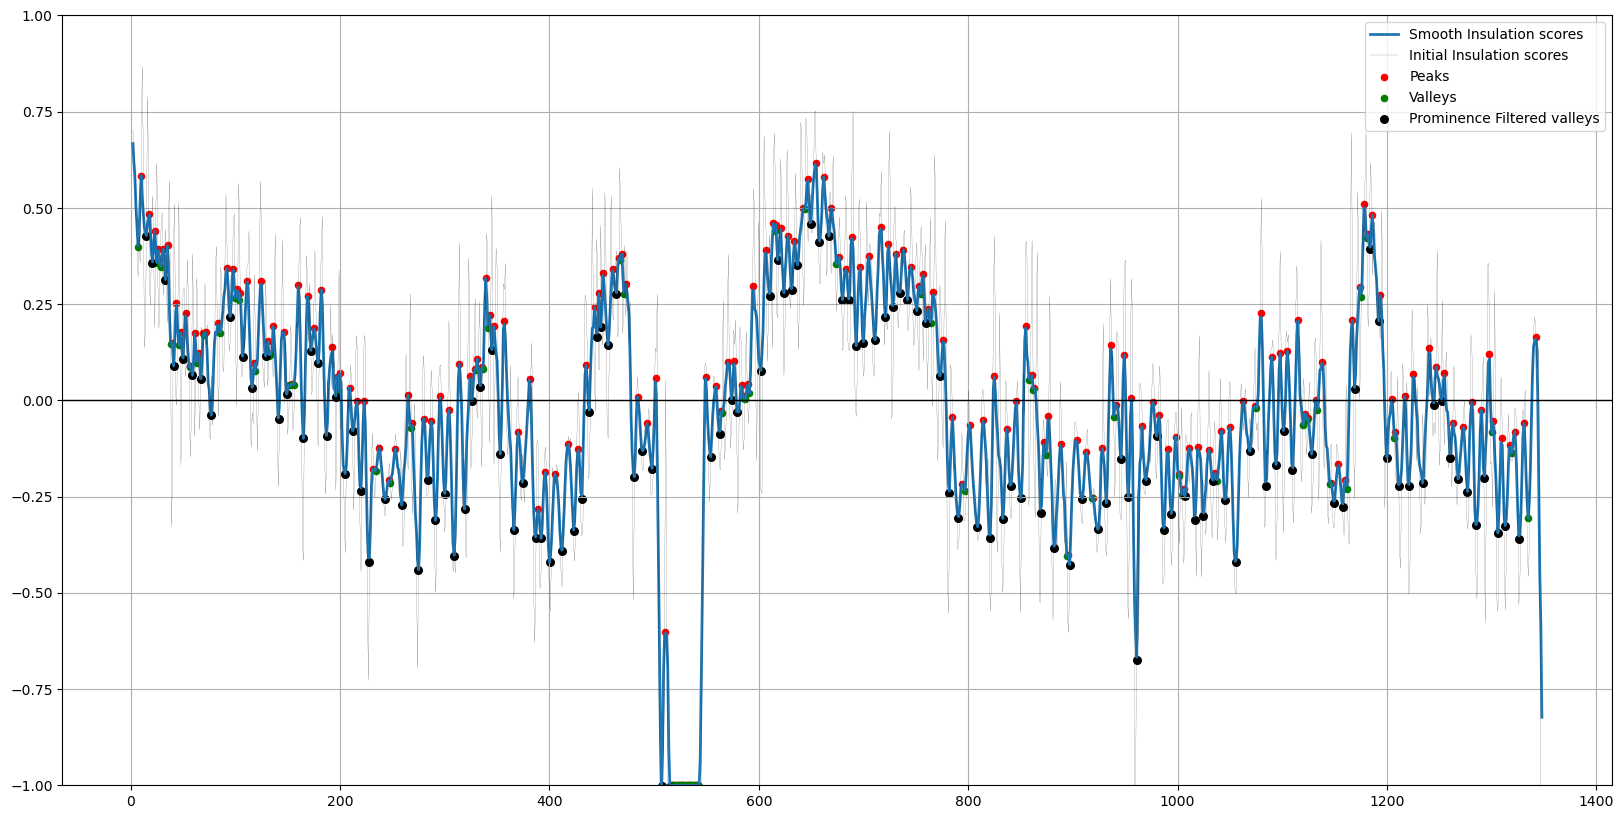

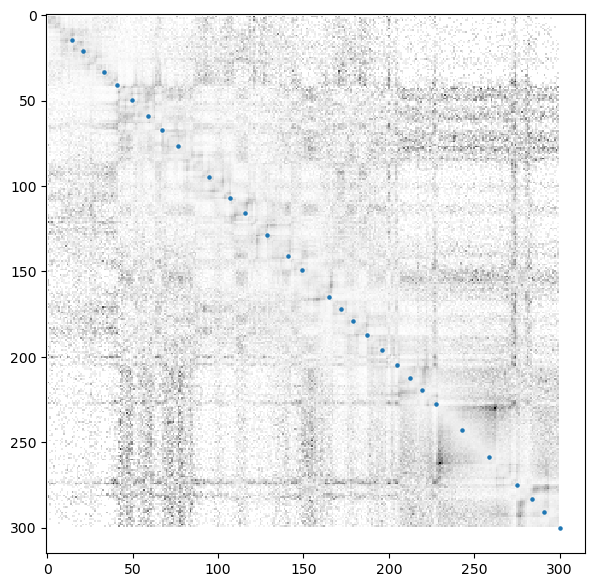

,chr,boundary
0,chr11,14
1,chr11,20
2,chr11,33
3,chr11,40
4,chr11,49
...,...,...
124,chr11,1285
125,chr11,1292
126,chr11,1306
127,chr11,1312


In [10]:
compute_TADs(data, filter_size = 5, smoothing_window = 5,prominence_threshold =0.05 , n = 29)